In [7]:
# <AUTOGEN_PATH_SETUP>
# Ensure project root is on import path & set CWD
import sys
import os
from pathlib import Path

cwd = Path.cwd().resolve()
if "notebooks" in cwd.parts:
    root = Path(*cwd.parts[: cwd.parts.index("notebooks")])
else:
    root = cwd.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.chdir(root)
print("Project root:", root)

Project root: /Users/wadoudcharbak/Documents/GitHub/Quant_Project


# 00 End‑to‑End Pipeline Demo
This notebook mirrors **`run_efa.py`** step‑by‑step so you can run, inspect, and tweak each stage interactively.

In [8]:
from pathlib import Path
import logging

from src.config import cfg
from src.data_loader import get_all_equities
from src.features import add_returns, add_rolling_features, prepare_feature_matrix
from src.model import train_model, predict
from src.backtest import run_backtest
from src.plotting import plot_equity

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger(__name__)

## 1 – Load configuration

In [9]:
p = cfg()
p

{'project': {'name': 'Equity Factor Alpha Engine', 'version': '0.1.0'},
 'base_currency': 'GBP',
 'assets': [{'ticker': 'LMT'},
  {'ticker': 'RTX'},
  {'ticker': 'BA'},
  {'ticker': 'NOC'},
  {'ticker': 'GD'},
  {'ticker': 'HII'},
  {'ticker': 'TDG'},
  {'ticker': 'TXT'},
  {'ticker': 'LHX'},
  {'ticker': 'BA.'}],
 'start_date': '2023-10-01',
 'end_date': None,
 'features': {'return_col': 'returns', 'windows': [5, 20, 60]},
 'model': {'objective': 'reg:squarederror',
  'max_depth': 3,
  'learning_rate': 0.1,
  'n_estimators': 200,
  'subsample': 0.8,
  'colsample_bytree': 0.8},
 'backtest': {'hold_days': 5,
  'top_n': 2,
  'notional': 1000,
  'fee_bps': 0.0,
  'risk_free_rate': 0.0},
 'paths': {'data_raw': 'data_raw',
  'data_proc': 'data_proc',
  'outputs': 'outputs',
  'logs': 'logs'}}

## 2 – Choose asset universe

In [10]:
selected_assets = [a["ticker"] for a in p["assets"]]
print("Selected assets:", selected_assets)

Selected assets: ['LMT', 'RTX', 'BA', 'NOC', 'GD', 'HII', 'TDG', 'TXT', 'LHX', 'BA.']


## 3 – Download / cache price data

In [11]:
start = "2023-07-01"
end = None

data = get_all_equities(force_refresh=True, start_date=start, end_date=end)
data = {t: df for t, df in data.items() if t in selected_assets}
logger.info("Loaded price data for %d tickers", len(data))
list(data.items())[:2]  # show sample

2025-07-29 11:50:23,699 | INFO | Loaded price data for 10 tickers


[('LMT',
                                   open        high        low       close  \
  2023-07-03 00:00:00+00:00  100.065075  100.195250  99.794764   99.991765   
  2023-07-04 00:00:00+00:00   99.804382   99.954287  99.748625   99.933111   
  2023-07-05 00:00:00+00:00   99.883516  100.065102  99.586534   99.696433   
  2023-07-06 00:00:00+00:00   99.999681  100.278484  99.979985  100.191355   
  2023-07-07 00:00:00+00:00   99.654136   99.778123  99.597277   99.709947   
  ...                               ...         ...        ...         ...   
  2024-06-24 00:00:00+00:00   79.499276   79.641032  79.343490   79.407336   
  2024-06-25 00:00:00+00:00   79.164136   79.242147  79.139086   79.191852   
  2024-06-26 00:00:00+00:00   78.222942   78.433888  78.188955   78.334329   
  2024-06-27 00:00:00+00:00   78.110331   78.257458  78.064541   78.232799   
  2024-06-28 00:00:00+00:00   77.871631   77.966047  77.780614   77.951345   
  
                                  volume  
  2023-07

## 4 – Feature engineering

In [12]:
processed = {}
for t, df in data.items():
    df = add_returns(df, price_col="close", out_col=p["features"]["return_col"])
    df.dropna(subset=[p["features"]["return_col"]], inplace=True)
    df = add_rolling_features(
        df, col=p["features"]["return_col"], windows=p["features"]["windows"]
    )
    processed[t] = df
logger.info("Feature engineering complete.")

2025-07-29 11:50:23,734 | INFO | Feature engineering complete.


## 5 – Prepare X and y matrices

In [13]:
X, y = prepare_feature_matrix(
    processed,
    windows=p["features"]["windows"],
    lookahead=1,
    return_col=p["features"]["return_col"],
)
benchmark = y.groupby(level=0).mean()
X.head()

,,open,high,low,close,volume,returns_mean_5,returns_std_5,returns_mom_5,returns_mean_20,returns_std_20,returns_mom_20,returns_mean_60,returns_std_60,returns_mom_60
date,ticker,,,,,,,,,,,,,,
2023-09-25 00:00:00+00:00,LMT,98.311036,98.698778,98.221723,98.515647,1543.102753,-0.001249,0.005099,-0.006246,-0.000760,0.010229,-0.015201,-0.000195,0.010320,-0.011688
2023-09-26 00:00:00+00:00,LMT,97.544317,97.713195,97.537448,97.562906,1678.316991,-0.001088,0.004809,-0.005440,-0.000644,0.010114,-0.012888,-0.000346,0.010391,-0.020772
2023-09-27 00:00:00+00:00,LMT,96.033339,96.346777,95.852144,96.186954,1046.576075,-0.004312,0.006684,-0.021562,-0.001013,0.010458,-0.020270,-0.000542,0.010536,-0.032507
2023-09-28 00:00:00+00:00,LMT,94.665511,94.893794,94.601664,94.742068,674.242834,-0.006765,0.007818,-0.033824,-0.002266,0.010559,-0.045327,-0.000875,0.010672,-0.052493
2023-09-29 00:00:00+00:00,LMT,95.560860,95.814356,95.423458,95.647315,1468.352002,-0.005070,0.009960,-0.025349,-0.001568,0.010852,-0.031357,-0.000636,0.010742,-0.038133


## 6 – Train XGBoost model

In [14]:
model, rmse = train_model(X, y, params=p["model"], test_size=0.2)
print(f"Validation RMSE: {rmse:.6f}")

Validation RMSE: 0.012535


## 7 – Generate predictions

In [15]:
preds = predict(model, X)
preds.head()

date                       ticker
2023-09-25 00:00:00+00:00  LMT       0.001680
2023-09-26 00:00:00+00:00  LMT       0.000331
2023-09-27 00:00:00+00:00  LMT      -0.003165
2023-09-28 00:00:00+00:00  LMT       0.000793
2023-09-29 00:00:00+00:00  LMT      -0.001639
Name: prediction, dtype: float32

## 8 – Run back‑test

In [16]:
results = run_backtest(
    predictions=preds,
    returns=y,
    benchmark_returns=benchmark,
    risk_free_rate=p["backtest"].get("risk_free_rate", 0.0),
    hold_days=p["backtest"]["hold_days"],
    top_n=p["backtest"]["top_n"],
    notional=p["backtest"]["notional"],
    fee_bps=p["backtest"]["fee_bps"],
)
equity = results["equity"]
metrics = results["metrics"]
metrics

{'total_net_pnl': np.float64(654.2358674453465),
 'num_trades': 667,
 'hit_rate': np.float64(0.5292353823088456),
 'avg_trade_ret': np.float64(0.000980863369483278),
 'max_drawdown_abs': 959.903501894705,
 'max_drawdown_pct': 1.1629886791995419,
 'sharpe': np.float64(-0.7473177482826228),
 'alpha': -0.017860126463009492,
 'beta': 1.97940431132751,
 'alpha_tstat': -0.9412329550619348}

## 9 – Visualise equity curve

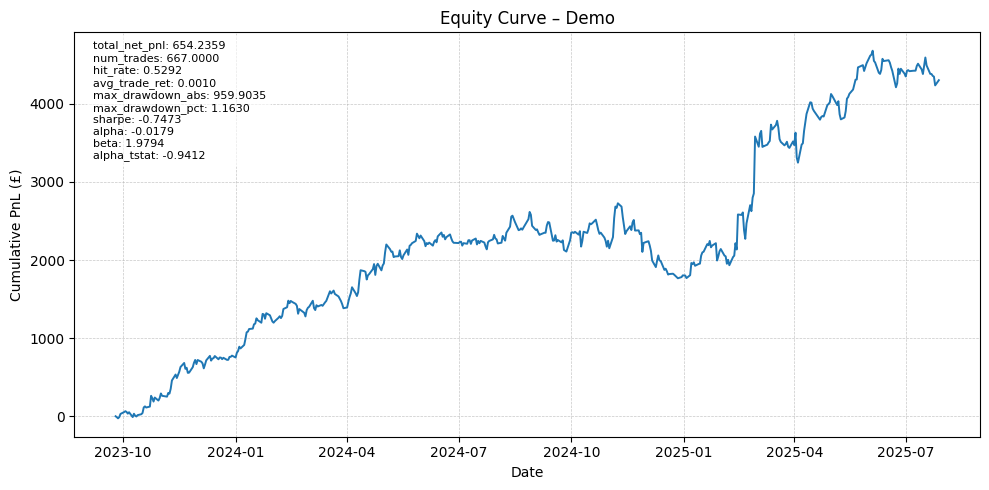

<Axes: title={'center': 'Equity Curve – Demo'}, xlabel='Date', ylabel='Cumulative PnL (£)'>

In [17]:
plot_equity(equity, title="Equity Curve – Demo", metrics=metrics)

---
### Notebook complete
You’ve now stepped through the entire `run_efa.py` workflow interactively. Feel free to tweak parameters in **`params.yaml`** and re‑run individual cells.